In [1]:
# this is the wrapper notebook
# 1) it shows how a regression model is created
# 2) how the model input and output and model weights get quantized
# 3) how the model weights and test set are exported as cairo inputs
# 4) how cairo script is invoked
# 5) how cairo proof is generated
# 7) how cairo prediction output is retrieved
# 8) cairo prediction output is dequantized
# 9) cairo prediction and native prediction is compared

In [2]:
import time
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from concrete.ml.sklearn import LinearRegression as ConcreteLinearRegression
from sklearn.model_selection import train_test_split
from concrete.ml.quantization import QuantizedArray
import json
from json import JSONEncoder
import re
from itertools import chain
import time

/home/mister/micromamba/envs/cairo1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display

# Create the training and test set

In [4]:
BITS=8
# pylint: disable=unbalanced-tuple-unpacking
WEIGHTS=1
X, y = make_regression(
    n_samples=200, n_features=WEIGHTS, n_targets=1, bias=5.0, noise=30.0, random_state=42
)
X = X + 3
y= y + 300
# pylint: enable=unbalanced-tuple-unpacking

# Split it into train/test and sort the sets for nicer visualization
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

#sidx = np.argsort(np.squeeze(x_train))
#x_train = x_train[sidx, :]
#y_train = y_train[sidx]

#sidx = np.argsort(np.squeeze(x_test))
#x_test = x_test[sidx, :]
#y_test = y_test[sidx]

In [5]:
linreg = SklearnLinearRegression()
tic = time.perf_counter()
linreg.fit(x_train, y_train)
toc = time.perf_counter()
print(f"Classic sklearn fitting {toc - tic:0.4f} seconds")
print(linreg.coef_)

Classic sklearn fitting 0.0051 seconds
[83.79904944]


In [6]:
tic = time.perf_counter()
y_pred = linreg.predict(x_test)
toc = time.perf_counter()
time_sklearn_model_predict = toc - tic
print(f"Classic sklearn model prediction {time_sklearn_model_predict:0.4f} seconds")

Classic sklearn model prediction 0.0006 seconds


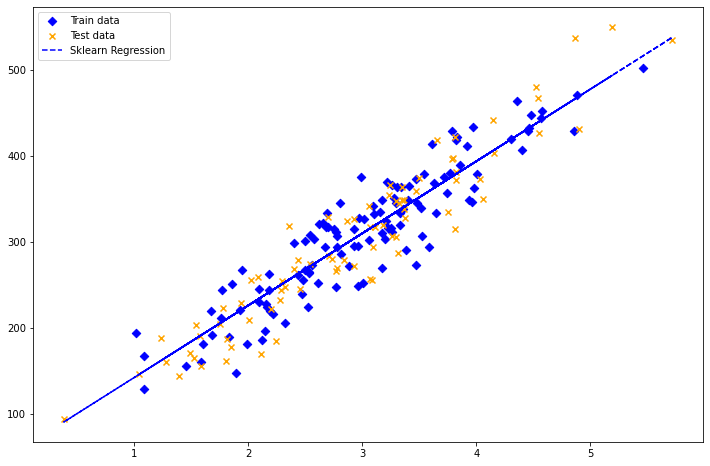

In [7]:
plt.ioff()

plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.scatter(x_train[:,0], y_train, c="blue", marker="D", label="Train data")
ax.scatter(x_test[:,0], y_test, c="orange", marker="x", label="Test data")
ax.plot(x_test[:,0], y_pred, c="blue", marker=None, linestyle="dashed", label="Sklearn Regression")
ax.legend()
display(fig)


#  how the model input and output and model weights get quantized
Open point: How to get the coefficient and intercept quantized? Somehow it should be possible to extract it from concrete ml?

In [8]:
# alternative zur quantisierung:
# bspw. multiplication beider seiten mit 100*100 = 10000
# X*w = y
# (X*100)*(w*100) = y*10000
QUANT_FACTOR_X = 10000
QUANT_FACTOR_W = 10000
QUANT_FACTOR_COMB = QUANT_FACTOR_X*QUANT_FACTOR_W
intercept_quant = round(linreg.intercept_ * QUANT_FACTOR_COMB)
weights_quant = np.round(linreg.coef_ * QUANT_FACTOR_W).astype(int).tolist()
x_quant = np.round(x_test * QUANT_FACTOR_X).astype(int).tolist()

# how the model weights and test set are exported as cairo inputs

In [9]:
# create dictionary for Cairo input for json serialization
json_data = {}
json_data["intercept"] = intercept_quant
json_data["weights"] =weights_quant
json_data["X"] = x_quant

In [10]:
json_data

{'intercept': 5865862202,
 'weights': [837990],
 'X': [[37818],
  [32970],
  [15753],
  [30686],
  [20806],
  [37910],
  [26989],
  [27083],
  [10403],
  [17543],
  [32420],
  [25394],
  [22463],
  [33142],
  [19377],
  [3803],
  [24337],
  [33616],
  [31846],
  [34738],
  [34967],
  [30870],
  [51905],
  [29256],
  [23200],
  [32961],
  [45499],
  [33614],
  [23549],
  [41586],
  [36566],
  [20253],
  [41428],
  [18038],
  [27659],
  [40571],
  [22979],
  [24556],
  [21105],
  [12751],
  [30675],
  [45380],
  [20095],
  [29272],
  [28387],
  [32323],
  [48658],
  [15877],
  [30582],
  [28617],
  [15215],
  [14852],
  [38125],
  [38135],
  [33436],
  [22856],
  [18087],
  [57202],
  [32611],
  [38221],
  [30918],
  [48968],
  [23983],
  [27353],
  [45230],
  [22802],
  [37519],
  [12370],
  [33757],
  [15365],
  [13925],
  [27742],
  [33241],
  [40310],
  [33464],
  [18490],
  [38219],
  [21977],
  [17792],
  [31109]]}

In [11]:
# create json numpy array encoder in order to be able to json serialize them
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [20]:
# write Cairo input data to json
CAIRO_INPUT_FILE = "data.json"
with open(CAIRO_INPUT_FILE, 'w', encoding='utf-8') as f:
    json.dump(json_data, f, ensure_ascii=False, indent=4, cls=NumpyArrayEncoder)

# how cairo script is invoked
how cairo proof is generated??

In [21]:
CAIRO_FILE = "linear_function.cairo"
CAIRO_FILE_COMPILED = "linear_function_compiled.json"
CAIRO_OUTPUT_FILE = "linear_function.output"

In [22]:
# compile Cairo program 
!cairo-compile {CAIRO_FILE} --output {CAIRO_FILE_COMPILED}
#!cairo-compile linear_function.cairo --output linear_function_compiled.json

In [23]:
# run Cairo program with generated input
# including parameters of trained model (intercep, coefficients) 
# and test data for prediction
# output is written to text file
!cairo-run --program={CAIRO_FILE_COMPILED} --print_output --layout=small --program_input={CAIRO_INPUT_FILE} > {CAIRO_OUTPUT_FILE}


# how cairo prediction output is retrieved

In [24]:
# read output of cairo program
with open(CAIRO_OUTPUT_FILE) as f:
    lines = f.readlines()
#lines    

In [25]:
# extract all numbers from output
s_nums = ["".join(re.findall(r'\d', line)) for line in lines]
s_nums = [int(n) for n in s_nums if n != ""]
# display the result list
print(s_nums)
y_hat_quant=s_nums[-1]
#result

[1, 5865862202, 37818, 837990, 37556968022]


In [26]:
# dequantize the cairo result y_hat_quant
# by dividing by the quantization factor
y_hat_dequant = y_hat_quant / QUANT_FACTOR_COMB
# calculate prediction from local model
y_hat_classic = linreg.predict([x_test[0]])[0]
# calculate deviation of Cairo prediction to local prediction
deviation = y_hat_dequant/y_hat_classic-1

print(f"y_hat_dequant: {y_hat_dequant:.2f}, y_hat_classic: {y_hat_classic:.2f}, \
deviation from classic: {deviation:.2f}")

y_hat_dequant: 375.57, y_hat_classic: 375.57, deviation from classic: -0.00


In [ ]:
#q_linreg.quantized_module.dequantize_output(result)
#q_linreg.quantized_module.quantize_input(x_test[0])

In [ ]:
#https://starknet.io/docs/sharp.html#sending-a-program-to-sharp

In [27]:
!cairo-sharp submit --source {CAIRO_FILE} --program_input {CAIRO_INPUT_FILE}

Compiling...
Running...
Submitting to SHARP...
Job sent.
Job key: 35e58596-c527-4334-99e2-9581a94cd6f1
Fact: 0xedabee909745223d47822abaa6fd721c4f547c3be117fa9878c59e4f42102f85


In [39]:
!cairo-sharp status 35e58596-c527-4334-99e2-9581a94cd6f1

IN_PROGRESS


In [101]:
CAIRO_SHARP_OUTPUT_FILE = "SHARP.OUTPUT"
!cairo-sharp submit --source {CAIRO_FILE} --program_input {CAIRO_INPUT_FILE} > {CAIRO_SHARP_OUTPUT_FILE}

Compiling...
Running...
Submitting to SHARP...
Job sent.


In [102]:
# read output of sharp program
with open(CAIRO_SHARP_OUTPUT_FILE) as f:
    lines = f.readlines()
# transform to dictionary    
l = [line.strip().split(":") for line in lines]
d = dict()
for k,v in l:
    d[k] = v.strip()
d

{'Job key': '5cb755c5-1ab0-4e7a-8e9d-1cea2f86f739',
 'Fact': '0xedabee909745223d47822abaa6fd721c4f547c3be117fa9878c59e4f42102f85'}

In [103]:
!cairo-sharp status {d["Job key"]}

IN_PROGRESS


In [104]:
import subprocess
result = subprocess.run(['cairo-sharp', 'status', d["Job key"]], stdout=subprocess.PIPE)
result

CompletedProcess(args=['cairo-sharp', 'status', '5cb755c5-1ab0-4e7a-8e9d-1cea2f86f739'], returncode=0, stdout=b'IN_PROGRESS\n')

In [ ]:
in_progress = True
tic = time.perf_counter()
while (in_progress):
    result_status = subprocess.run(['cairo-sharp', 'status', d["Job key"]], stdout=subprocess.PIPE)
    toc = time.perf_counter()
    print(f"Time spend {(toc - tic)/60:0.1f} minutes", result)
    if result_status.returncode != 0:
        break
    in_progress = result.stdout.strip() == b"IN_PROGRESS"
    time.sleep(120)


In [ ]:
#https://githubplus.com/uqbar-dao/zock
#https://www.cairo-lang.org/playground-sharp-alpha/
#https://goerli.etherscan.io/address/0xAB43bA48c9edF4C2C4bB01237348D1D7B28ef168

NODE_URL = "https://goerli-light.eth.linkpool.io/v2/0xAB43bA48c9edF4C2C4bB01237348D1D7B28ef168"
#NODE_URL = 'https://eth-goerli.alchemyapi.io/v2/HYoJ9w4vu0iEOru4z0XcceAcedvcXj4a'
result_verification = subprocess.run(['cairo-sharp', 'is_verified',
                                      '--node_url', NODE_URL ,  
                                      #d["Job key"]], 
                                      d["Fact"]], 
                                     stdout=subprocess.PIPE)
print(result_verification)
is_verified = result_verification.stdout.strip() == b'True'
is_verified